This notebook is the second part of an introduction to machine learning and implements an Multilayer Perceptron (MLP) for a binary classification task, from scratch.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles

Dim of X: (2, 200)
Dim of Y: (1, 200)


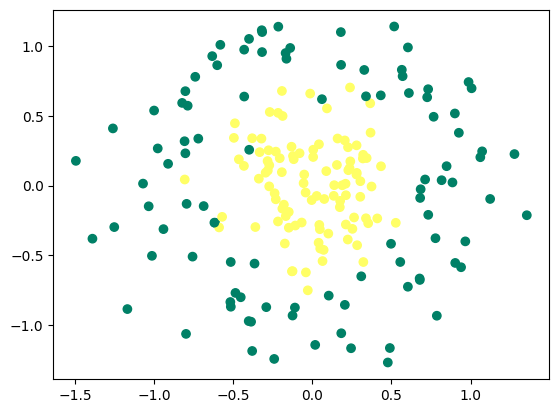

In [2]:
X,Y = make_circles(n_samples=200, noise=0.2, factor=0.3, random_state=0)
X = X.T
Y = Y.reshape((1,Y.shape[0]))

print(f"Dim of X: {X.shape}")
print(f"Dim of Y: {Y.shape}")

plt.scatter(X[0,:], X[1,:], c=Y, cmap='summer')
plt.show()

In [3]:
def initialisation(n0, n1, n2): 
    # n0:nb entree, n1: nb neurone, n2: sortie
    W1 = np.random.randn(n1, n0)
    b1 = np.random.randn(n1, 1)
    W2 = np.random.randn(n2, n1)
    b2 = np.random.randn(n2, 1)

    parameters = {
        'W1' : W1,
        'b1' : b1,
        'W2' : W2,
        'b2' : b2
    }
    
    return(parameters)

In [4]:
def log_loss(A,Y):
    m = Y.shape[1]
    return(-1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A)))

In [5]:
def sigmoid(x):
    return(1/(1+np.exp(-x)))

In [6]:
def foward_propagation(parameters, X):
    # we take X through the network and return the activations
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    Z1 = W1.dot(X) + b1
    A1 = sigmoid(Z1)

    Z2 = W2.dot(A1) + b2
    A2 = sigmoid(Z2)

    activations = {
        'A1' : A1,
        'A2' : A2
    }

    return activations



In [7]:
def back_propagation(parameters, activations, X, Y):
    m = X.shape[1]
    A1, A2 = activations['A1'], activations['A2']
    W2 = parameters['W2']

    dZ2 = A2 - Y
    dZ1 = (W2.T).dot(dZ2) * A1 * (1 - A1)

    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)

    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {
        'dW1' : dW1,
        'db1' : db1,
        'dW2' : dW2,
        'db2' : db2
    }

    return(gradients)


In [8]:
def update(parameters, gradients, lr):
    parameters['W1'] -= lr * gradients['dW1']
    parameters['b1'] -= lr * gradients['db1']
    parameters['W2'] -= lr * gradients['dW2']
    parameters['b2'] -= lr * gradients['db2']
    return(parameters)

In [9]:
# we see A as the probability for y=1
def predict(parameters, X):
    activations = foward_propagation(parameters, X)
    return activations['A2'] >= 0.5

In [10]:
from sklearn.metrics import accuracy_score
from matplotlib.animation import PillowWriter
from tqdm import tqdm

In [11]:
Params_history = []
Loss = []
Acc = []

In [12]:
def artificial_neuron(n1, X, Y, lr=0.001, n_iter=200000):
    n0, n2 = X.shape[0], Y.shape[0]
    parameters = initialisation(n0, n1, n2)

    for i in range(n_iter):
        activations = foward_propagation(parameters, X)
        
        gradients = back_propagation(parameters, activations, X, Y)
        parameters = update(parameters, gradients, lr)
        if i % 100 == 0:
            Loss.append(log_loss(activations['A2'],Y))
            Y_pred = predict(parameters, X)
            Acc.append(accuracy_score(Y.ravel(), Y_pred.ravel()))
            Params_history.append({k: v.copy() for k, v in parameters.items()})

    print(Acc[-1])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(Loss, label="train loss")
    ax1.set_xlabel("steps")
    ax1.set_ylabel("loss")
    ax1.legend()

    ax2.plot(Acc, label="train acc")
    ax2.set_xlabel("steps (/100)")
    ax2.set_ylabel("accuracy")
    ax2.legend()

    plt.tight_layout()
    plt.show()



    return(parameters)
    
    

0.94


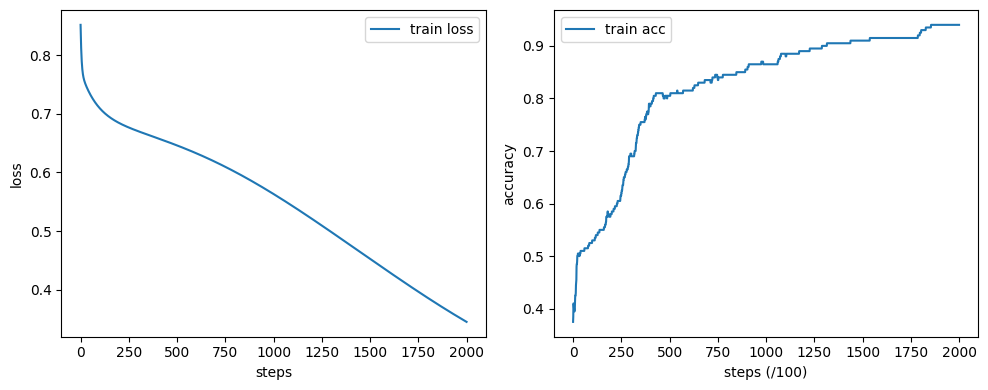

In [13]:
parameters = artificial_neuron(16,X,Y)

Dim of X: (2, 200)
Dim of Y: (1, 200)


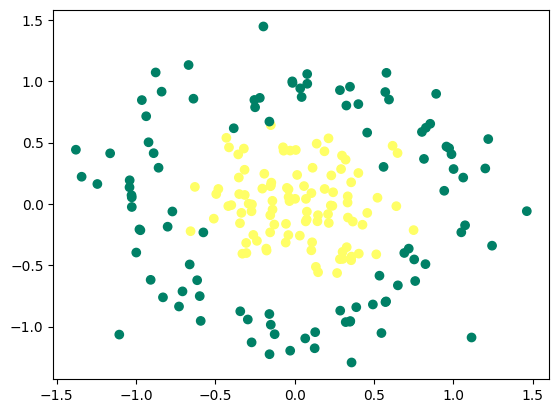

In [14]:
# Tests 

X_test, Y_test = make_circles(n_samples=200, noise=0.2, factor=0.3, random_state=2)
X_test = X_test.T
Y_test = Y_test.reshape((1,Y_test.shape[0]))

print(f"Dim of X: {X_test.shape}")
print(f"Dim of Y: {Y_test.shape}")

plt.scatter(X_test[0,:], X_test[1,:], c=Y_test, cmap='summer')
plt.show()

In [15]:
Y_pt = predict(parameters, X_test)
print(accuracy_score(Y_test.ravel(), Y_pt.ravel()))

0.955


/tmp/ipykernel_8965/2366091407.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


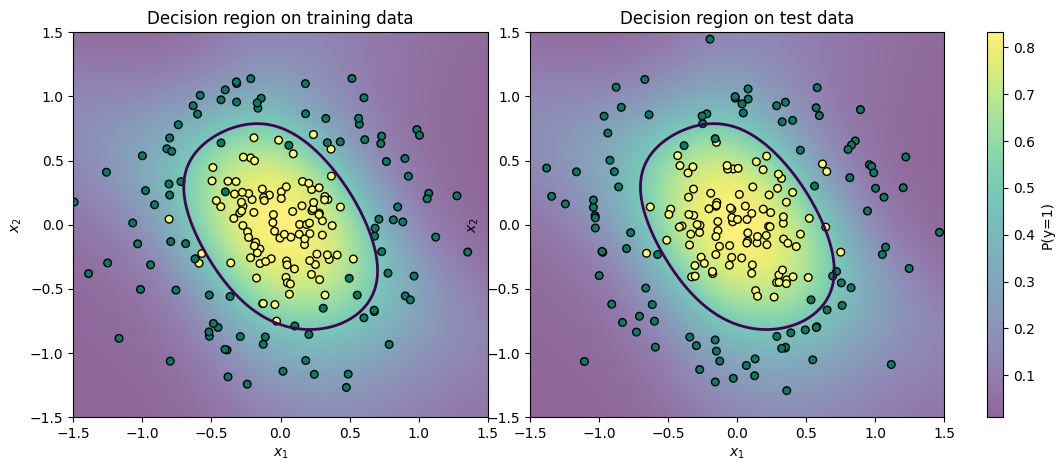

In [16]:
# Drawing the decision bounderie
N = 200
xv = np.linspace(-1.5, 1.5, N)
xx, yy = np.meshgrid(xv, xv)

X_grid = np.vstack([xx.ravel(), yy.ravel()])          # (2, N*N)
A2 = foward_propagation(parameters, X_grid)['A2']     # (1, N*N)
A2_map = A2.reshape(N, N)                             # (N, N)

# --- Plot: train vs test ---
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.04], wspace=0.15)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
cax = fig.add_subplot(gs[0, 2])  # dedicated colorbar axis


# Common background on both axes
for ax in (ax1, ax2):
    im = ax.imshow(
        A2_map,
        extent=[xv.min(), xv.max(), xv.min(), xv.max()],
        origin="lower",
        aspect="auto",
        alpha=0.6
    )
    ax.contour(xx, yy, A2_map, levels=[0.5], linewidths=2)  # decision boundary
    ax.set_xlim(xv.min(), xv.max())
    ax.set_ylim(xv.min(), xv.max())
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

# Scatter train (left)
ax1.scatter(X[0, :], X[1, :], c=Y.ravel(), cmap="summer", edgecolors="k", s=30)
ax1.set_title("Decision region on training data")

# Scatter test (right)
ax2.scatter(X_test[0, :], X_test[1, :], c=Y_test.ravel(), cmap="summer", edgecolors="k", s=30)
ax2.set_title("Decision region on test data")

# One colorbar for the whole figure
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("P(y=1)")

plt.tight_layout()
plt.show()


Global animation :

In [23]:
from matplotlib.animation import PillowWriter

def animate_full_training(
    Loss, Acc, Params_history,
    X, Y, X_test, Y_test,
    out_path="../assets/mlp_full.gif",
    fps=30,
    frame_step=10,
    N=200,
    xmin=-1.5, xmax=1.5
):
    # ----- Grid (fixed) -----
    xv = np.linspace(xmin, xmax, N)
    xx, yy = np.meshgrid(xv, xv)
    X_grid = np.vstack([xx.ravel(), yy.ravel()])  # (2, N*N)

    # ----- Figure layout: 2x2 + one colorbar axis on the right -----
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.05], wspace=0.25, hspace=0.25)

    ax_loss = fig.add_subplot(gs[0, 0])
    ax_acc  = fig.add_subplot(gs[0, 1])
    ax_tr   = fig.add_subplot(gs[1, 0])
    ax_te   = fig.add_subplot(gs[1, 1], sharex=ax_tr, sharey=ax_tr)
    cax = fig.add_subplot(gs[1, 2]) 

    # ----- Top-left: loss line -----
    (line_loss,) = ax_loss.plot([], [], label="train loss")
    ax_loss.set_xlabel("checkpoint")
    ax_loss.set_ylabel("loss")
    ax_loss.set_xlim(0, len(Loss) - 1)
    ax_loss.set_ylim(min(Loss), max(Loss))
    ax_loss.legend()

    # ----- Top-right: acc line -----
    (line_acc,) = ax_acc.plot([], [], label="train acc")
    ax_acc.set_xlabel("checkpoint")
    ax_acc.set_ylabel("accuracy")
    ax_acc.set_xlim(0, len(Acc) - 1)
    ax_acc.set_ylim(0, 1)
    ax_acc.legend()

    # ----- Bottom: initial decision maps -----
    A2_0 = foward_propagation(Params_history[0], X_grid)["A2"]  # (1, N*N)
    A2_map_0 = A2_0.reshape(N, N)

    im_tr = ax_tr.imshow(
        A2_map_0,
        extent=[xmin, xmax, xmin, xmax],
        origin="lower",
        aspect="auto",
        alpha=0.6,
        vmin=0,
        vmax=1
    )

    im_te = ax_te.imshow(
        A2_map_0,
        extent=[xmin, xmax, xmin, xmax],
        origin="lower",
        aspect="auto",
        alpha=0.6
    )

    # colorbar (shared)
    cbar = fig.colorbar(im_tr, cax=cax)
    cbar.set_label("P(y=1)")

    # scatter points (static)
    ax_tr.scatter(X[0, :], X[1, :], c=Y.ravel(), cmap="summer", edgecolors="k", s=25)
    ax_te.scatter(X_test[0, :], X_test[1, :], c=Y_test.ravel(), cmap="summer", edgecolors="k", s=25)

    for ax in (ax_tr, ax_te):
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(xmin, xmax)
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")

    ax_tr.set_title("Decision region (train)")
    ax_te.set_title("Decision region (test)")

    # initial contours (we will delete & redraw each frame)
    contour_tr = ax_tr.contour(xx, yy, A2_map_0, levels=[0.5], linewidths=2)
    contour_te = ax_te.contour(xx, yy, A2_map_0, levels=[0.5], linewidths=2)

    def remove_contour(cont):
        # Robust across matplotlib versions
        try:
            cont.remove()   # works in newer matplotlib
        except Exception:
            # fallback: remove every artist attached to the contour set
            for art in getattr(cont, "artists", []):
                art.remove()


    # ----- Animation writer -----
    metadata = dict(title="MLP Training", artist="Matthieu")
    writer = PillowWriter(fps=fps, metadata=metadata)

    with writer.saving(fig, out_path, 100):
        for k in tqdm(range(0, len(Loss), frame_step)):
            # update curves up to k
            x = np.arange(k + 1)
            line_loss.set_data(x, Loss[:k+1])
            line_acc.set_data(x, Acc[:k+1])

            # update decision maps using params snapshot at k
            A2 = foward_propagation(Params_history[k], X_grid)["A2"]
            A2_map = A2.reshape(N, N)

            im_tr.set_data(A2_map)
            im_te.set_data(A2_map)

            # update contour (remove old, draw new)
            remove_contour(contour_tr)
            remove_contour(contour_te)
            contour_tr = ax_tr.contour(xx, yy, A2_map, levels=[0.5], linewidths=2)
            contour_te = ax_te.contour(xx, yy, A2_map, levels=[0.5], linewidths=2)

            writer.grab_frame()

    plt.close(fig)
    print(f"Saved GIF to: {out_path}")


In [24]:
animate_full_training(Loss, Acc, Params_history, X, Y, X_test, Y_test)

100%|██████████| 200/200 [00:28<00:00,  6.92it/s]


Saved GIF to: ../assets/mlp_full.gif
